In [38]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,8)

In [39]:
import scipy as sp
import pandas as pd
from scipy import special
import sympy as s
from sympy.physics import wigner
import sys
from sys import float_info
EPS = float_info.epsilon
from scipy import optimize

In [40]:
class env:
    def __init__(self):
        self.alphaS = 0.3683
        self.b = 0.2062
        self.mu = 0.05611
        self.mC = 4.7572
        self.muR = self.mC/2
        self.sigma = 3.1025
        self.rC = 0.06012/0.19732697
        
        self.s1 = 0.5
        self.s2 = 0.5
        self.s = None
        self.j = None
        self.l = None     
        
        self.E = None
    
    def sdelta(self,r):
        return (self.sigma/sp.sqrt(sp.pi))**3*sp.exp(-self.sigma**2*r**2)
    def m2E(self, m):
        return m - 2*self.mC
    def E2m(self, E):
        return E + 2*self.mC

    def Vv(self,r):
        return -4/3*self.alphaS/r
    def dVv(self,r):
        return 4/3*self.alphaS/r**2
    def ddVv(self,r):
        return -8/3*self.alphaS/r**3

    def Vs(self,r):
        return self.b/self.mu*(1-sp.exp(-self.mu*r))
    def dVs(self,r):
        return self.b*sp.exp(-self.mu*r)

    def Vss(self,r):
        return 32*sp.pi*self.alphaS/9/self.mC**2*self.sdelta(r)*(self.s*(self.s+1) - self.s1*(self.s1+1) - self.s2*(self.s2+1))/2

    def Vsl(self,r):
        return 1/2/self.mC**2/r*(3*self.dVv(r) - self.dVs(r))*(self.j*(self.j+1)-self.l*(self.l+1)-self.s*(self.s+1))/2

    def St(self,):
        return 4*(self.s*(self.s+1)*self.l*(self.l+1)-3/2*(self.j*(self.j+1) - self.l*(self.l+1) - self.s*(self.s+1))/2-3*((self.j*(self.j+1) - self.l*(self.l+1) - self.s*(self.s+1))/2)**2)/(2*self.l+3)/(2*self.l-1)
    def Vt(self,r):
        return 1/12/self.mC**2*(1/r*self.dVv(r)-self.ddVv(r))*self.St()

    def Vq(self,r):
        try:
            rEff = sp.array([(rx if rx > self.rC else self.rC) for rx in r])
        except TypeError:
            rEff = r if r > self.rC else self.rC
        return self.Vv(rEff) + self.Vs(rEff) + self.Vss(rEff) + self.Vsl(rEff) + self.Vt(rEff)

    def T(self,r):
        return -2*self.muR*(self.E - self.Vq(r) - self.l*(self.l+1)/2/self.muR/r**2)



In [41]:
class gowel:
    def __init__(self):
        self.r = None
        self.u = None
        self.Tu = None
        self.h = None
        
        self.env = env()
    
    def reset(self):
        self.r = 0.
        self.u = sp.array([0., self.h**(self.env.l+1)])
        self.Tu = sp.array([2. if self.env.l < 1.2 and self.env.l > 0.8 else 0., self.env.T(self.h)*self.h**(self.env.l + 1)])
    
    def step(self):
        self.r = self.r+self.h
        tNow = self.env.T(self.r)
        self.u[0] = ((2*self.u[1]+5/6*self.h**2*self.Tu[1]) - (self.u[0]-1/12*self.h**2*self.Tu[0]))/(1 - 1/12*self.h**2*tNow)
        self.u[0], self.u[1] = self.u[1], self.u[0]
        self.Tu[0] = self.Tu[1]
        self.Tu[1] = tNow*self.u[1]
        return (self.r, self.u[1])

In [42]:
class eigens:
    def __init__(self):
        self.stpr = gowel()
        self.cutscale = None
        self.numpoints = None
        self.dist = None
        
    def f(self, E):
        tmpE = self.stpr.env.E
        self.stpr.env.E = E
        self.stpr.reset()
        while (self.stpr.r < self.cutscale):
            self.stpr.step()
        self.stpr.env.E = tmpE
        return sp.absolute(self.stpr.u[1]*sp.exp(-sp.sqrt(2*self.stpr.env.muR*sp.absolute(self.stpr.env.E))*self.cutscale))
    
    def fPoints(self):
        points = sp.linspace(self.stpr.env.E - self.dist, self.stpr.env.E + self.dist, self.numpoints)
        return sp.array([(p, self.f(p)) for p in points])
    
    def plotScales(self, cutscales):
        data= list()
        for scale in cutscales:
            self.cutscale = scale
            data.append(self.fPoints())
        for scale, thedata in zip(cutscales, data):
            plt.plot(*thedata.T, label=str(scale), ls=None, marker="o")
        plt.axvline(self.stpr.env.E, ls="--")
        plt.legend()
        plt.gca().set_yscale("log")
    
    def findMin(self):
        obj = sp.optimize.minimize(self.f, self.stpr.env.E, bounds=[(self.stpr.env.E-self.dist, self.stpr.env.E+self.dist)])
        self.stpr.env.E = obj.x
        return (obj.x, obj.fun)
    
    def plotU(self, rmax=None):
        if rmax is None:
            rmax = self.cutscale
        self.stpr.reset()
        points = list()
        while self.stpr.r < rmax:
            points.append(self.stpr.step())
        points = sp.array(points)
        plt.plot(points.T[0], points.T[1]**2, ls=None, marker="o")
        plt.axhline(0, ls="--")
        plt.axvline(7, ls="--")


In [43]:
eigs = eigens()
eigs.stpr.h = 1E-2

eigs.dist = 8E-3
eigs.numpoints = 30
eigs.cutscale = None

# $\chi_{b0}(1P)$

In [44]:
eigs.stpr.env.j = 0
eigs.stpr.env.l = 1
eigs.stpr.env.s = 1

In [45]:
eigs.stpr.env.E = eigs.stpr.env.m2E(9.864)

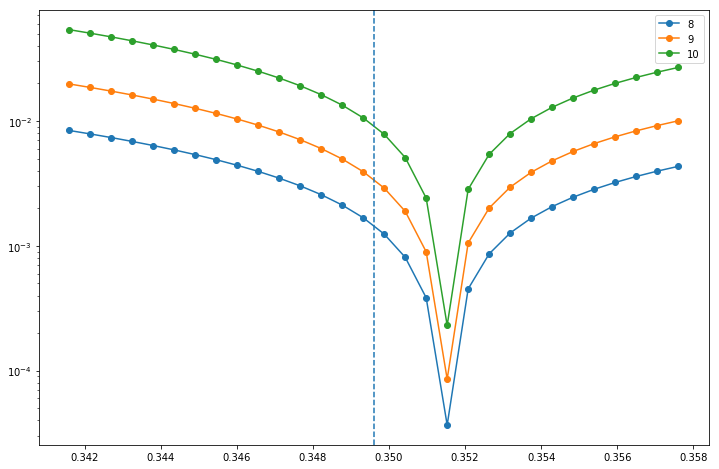

In [46]:
eigs.plotScales([8,9,10])

In [47]:
eigs.cutscale = 10

In [48]:
eigs.findMin()
print(eigs.stpr.env.E)
print(eigs.stpr.env.E2m(eigs.stpr.env.E))

[ 0.35148258]
[ 9.86588258]


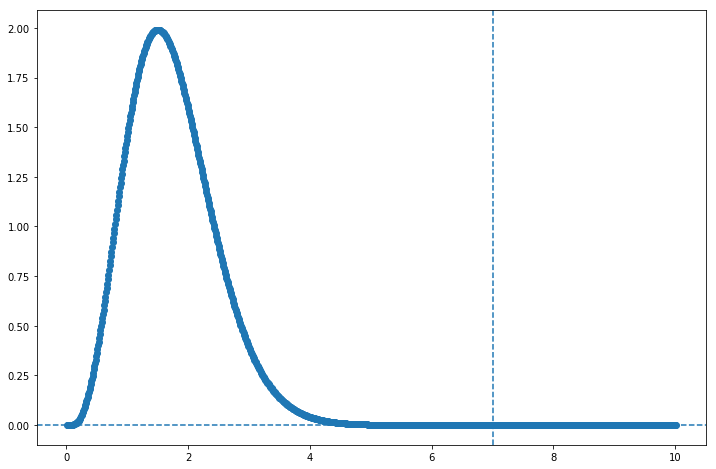

In [49]:
eigs.stpr.env.E = eigs.stpr.env.m2E(9.86588258)
eigs.plotU()

# $\Upsilon(4S)$

In [50]:
eigs.stpr.env.j = 1
eigs.stpr.env.l = 0
eigs.stpr.env.s = 1

In [51]:
eigs.stpr.env.E = eigs.stpr.env.m2E(10.597)+0.01

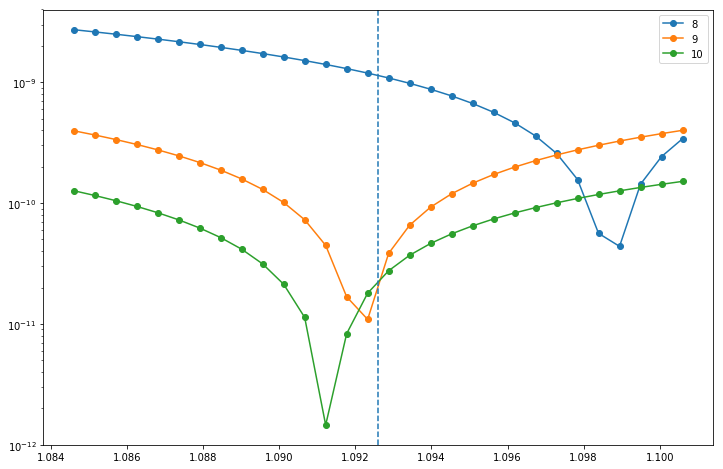

In [52]:
eigs.plotScales([8, 9, 10])

In [53]:
eigs.cutscale = 18

In [54]:
print(eigs.findMin())
print(eigs.stpr.env.E2m(eigs.stpr.env.E))

(array([ 1.0926]), 1.9042130843893911e-12)
[ 10.607]


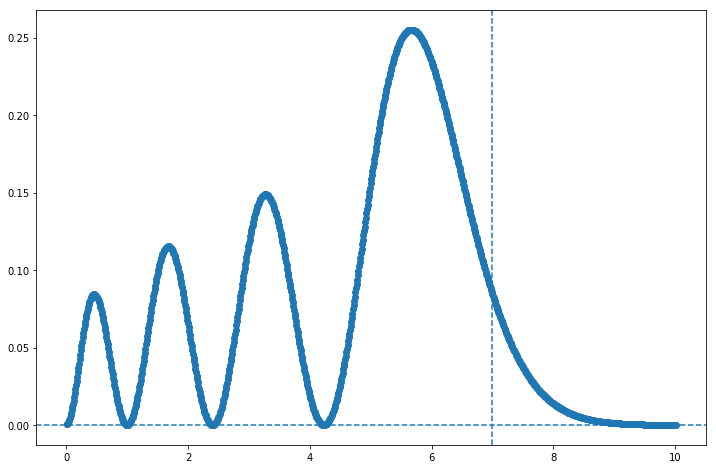

In [55]:
eigs.stpr.env.E = eigs.stpr.env.m2E(10.60564138)
eigs.plotU(10)

# $\Upsilon(3S)$

In [56]:
eigs.stpr.env.j = 1
eigs.stpr.env.l = 0
eigs.stpr.env.s = 1

In [57]:
eigs.stpr.env.E = eigs.stpr.env.m2E(10.343)+0.01

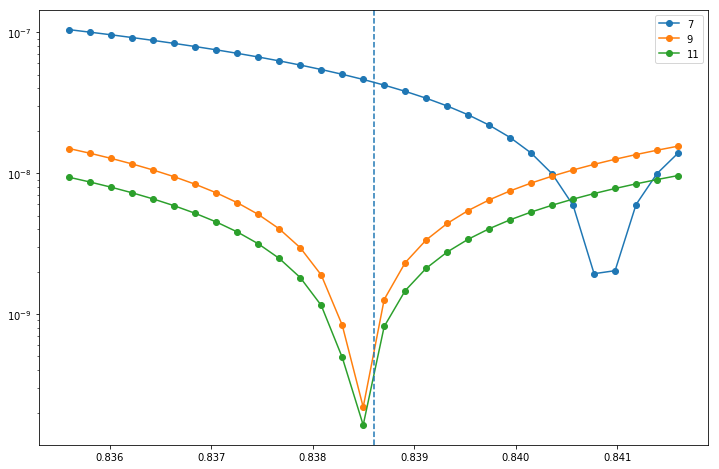

In [58]:
eigs.dist = 3E-3
eigs.plotScales([7, 9, 11])

In [59]:
eigs.cutscale = 20

In [60]:
print(eigs.findMin())
print(eigs.stpr.env.E2m(eigs.stpr.env.E))

(array([ 0.83844501]), 7.1079176779736496e-13)
[ 10.35284501]


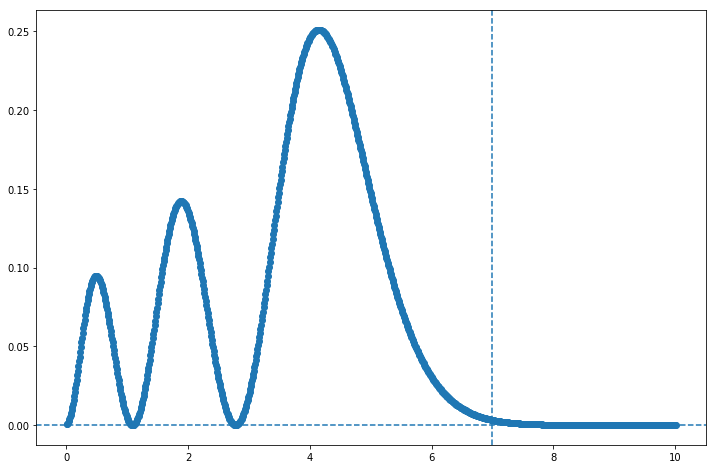

In [61]:
eigs.stpr.env.E = eigs.stpr.env.m2E(10.35284501)
eigs.plotU(10)


# $\Upsilon(1S)$

In [62]:
eigs.stpr.env.j = 1
eigs.stpr.env.l = 0
eigs.stpr.env.s = 1

In [63]:
eigs.stpr.env.E = eigs.stpr.env.m2E(9.497)
eigs.stpr.h = 1E-3

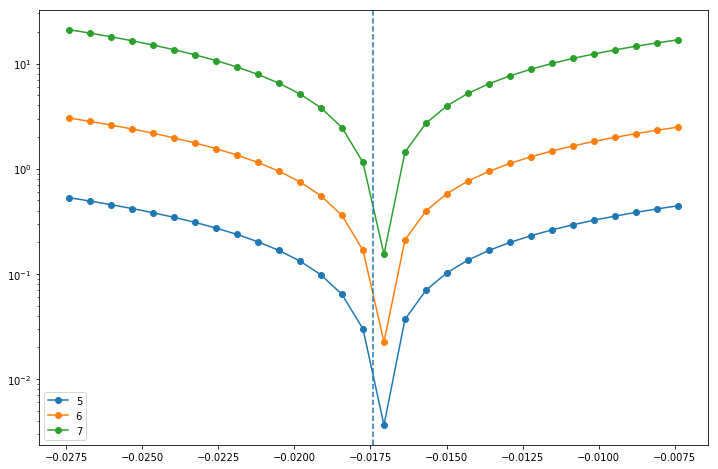

In [64]:
eigs.dist = 1E-2
eigs.plotScales([5, 6, 7])

In [65]:
eigs.cutscale = 7

In [66]:
print(eigs.findMin())
print(eigs.stpr.env.E2m(eigs.stpr.env.E))

(array([-0.01713717]), 1.336049480212566e-06)
[ 9.49726283]


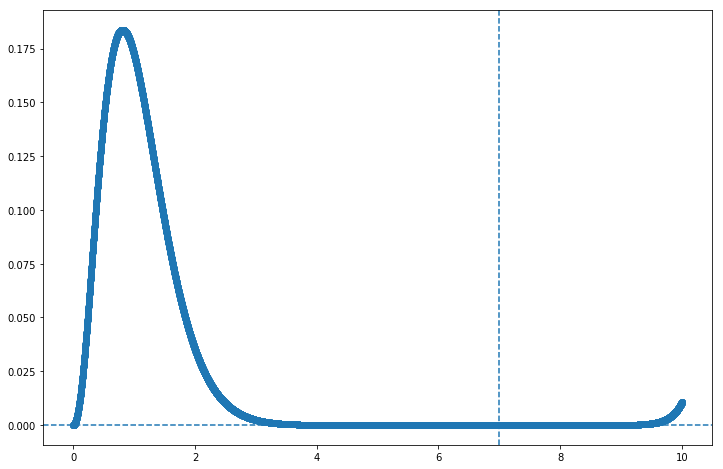

In [67]:
eigs.stpr.env.E = eigs.stpr.env.m2E(9.49726283)
eigs.plotU(10)
